In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark import SparkContext
sc = SparkContext(master="local", appName="New Spark Context")

In [3]:
from pyspark.sql import Row, SQLContext
from pyspark.sql import SparkSession
spark = SparkSession(sc)

In [4]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col

In [5]:
df = spark.read.csv("Cung cap du lieu buoi 4/2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

In [8]:
df.printSchema()

root
 |-- No: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: integer (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SalesClosePrice: integer (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: integer (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: integer (nullable = true)
 |-- PricePerTSFT: double (nullable = true)
 |-- FOUNDATIONSIZE: integer (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: integer (nullable = true)
 |-- offmarketdate: string (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- RoomArea4: string (nullable = 

In [9]:
from pyspark.sql.functions import datediff

In [10]:
# Sum two columns
df = df.withColumn('TSQFT', (df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND']))

# Divide two columns
df = df.withColumn('PRICEPERTSQFT', (df['LISTPRICE']/ df['TSQFT']))

# Difference two columns
df = df.withColumn('DAYSONMARKET', datediff('OFFMARKETDATE', 'LISTDATE'))

In [11]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print('Corr of FOUNDATIONSIZE vs SalesClosePrice:' + str(df.corr('FOUNDATIONSIZE', 'SalesClosePrice')))


Corr of FOUNDATIONSIZE vs SalesClosePrice:0.6152231695664401


In [13]:
# Ratio: BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS']/df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|       3|         2|
|1.3333333333333333|       4|         3|
|               2.0|       2|         1|
|               1.0|       2|         2|
|               1.5|       3|         2|
+------------------+--------+----------+
only showing top 5 rows



In [16]:
# https://docs.oracle.com/javase/7/docs/api/java/util/regex/Pattern.html
# https://docs.data.world/documentation/sql/reference/functions/regexp_extract.html

In [18]:
# Convert to date type
func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M'), DateType())
df = df.withColumn('LISTDATE_new', func(col('LISTDATE')))
# df = df.withColumn('LISTDATE_new', to_date('LISTDATE'))

# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE_new'))

# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

In [19]:
sample_df[['LISTDATE', 'LISTDATE_new', 'List_Day_of_Week']].head(5)

,LISTDATE,LISTDATE_new,List_Day_of_Week
0,9/12/2017 0:00,2017-09-12,3
1,6/8/2017 0:00,2017-06-08,5
2,11/5/2017 0:00,2017-11-05,1
3,10/12/2017 0:00,2017-10-12,5
4,5/19/2017 0:00,2017-05-19,6


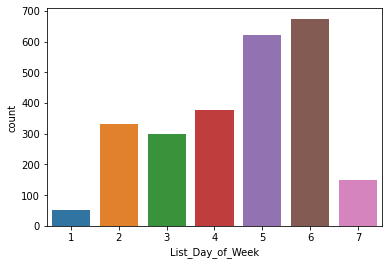

In [20]:
# Plot count plot of day of week
ax = sns.countplot(x='List_Day_of_Week', data=sample_df)
plt.show()

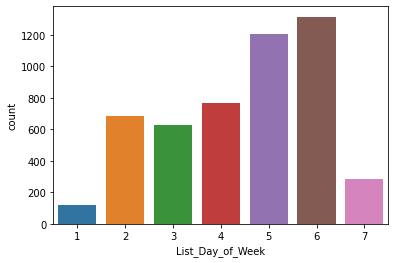

In [22]:
ax = sns.countplot(x='List_Day_of_Week', data=df.toPandas())
plt.show()

- Extracting Feature

In [23]:
# Import needed functions
from pyspark.sql.functions import when
# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')
# Conditional value assignment
df = df.withColumn('has_attached_garage', (when(has_attached_garage,1)
                                          .when(has_detached_garage,0)
                                          .otherwise(None)))
# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(truncate=50, n=3)

+--------------------------------------------------+-------------------+
|                                 GARAGEDESCRIPTION|has_attached_garage|
+--------------------------------------------------+-------------------+
|                                   Attached Garage|                  1|
|Attached Garage, Driveway - Asphalt, Garage Doo...|                  1|
|                                   Attached Garage|                  1|
+--------------------------------------------------+-------------------+
only showing top 3 rows



- Splitting

In [24]:
from pyspark.sql.functions import split
# Split the column on commas into a list
split_col = split(df['ROOF'], ',')
# Put the first value of the list into a new column
df = df.withColumn('Roof_Material', split_col.getItem(0))
# Inspect results
df[['ROOF', 'Roof_Material']].show(5, truncate=100)

+----------------------------------------------+----------------+
|                                          ROOF|   Roof_Material|
+----------------------------------------------+----------------+
|                                          null|            null|
|Asphalt Shingles, Pitched, Age 8 Years or Less|Asphalt Shingles|
|                                          null|            null|
|Asphalt Shingles, Pitched, Age 8 Years or Less|Asphalt Shingles|
|            Asphalt Shingles, Age Over 8 Years|Asphalt Shingles|
+----------------------------------------------+----------------+
only showing top 5 rows



- Exploding

In [25]:
# Import needed functions
from pyspark.sql.functions import split, explode
# Convert string to list-like array
df = df.withColumn('roof_list', split(df['ROOF'], ','))
df[['No', 'roof_list']].show(4, truncate=50)

# Explode the values into new records
roof_df = df.withColumn('ex_roof_list', explode(df['roof_list']))

# Inspect the values
roof_df[['No', 'ex_roof_list']].show(n=5, truncate=50)

+---+--------------------------------------------------+
| No|                                         roof_list|
+---+--------------------------------------------------+
|  1|                                              null|
|  2|[Asphalt Shingles,  Pitched,  Age 8 Years or Less]|
|  3|                                              null|
|  4|[Asphalt Shingles,  Pitched,  Age 8 Years or Less]|
+---+--------------------------------------------------+
only showing top 4 rows

+---+--------------------+
| No|        ex_roof_list|
+---+--------------------+
|  2|    Asphalt Shingles|
|  2|             Pitched|
|  2| Age 8 Years or Less|
|  4|    Asphalt Shingles|
|  4|             Pitched|
+---+--------------------+
only showing top 5 rows



- Pivot

In [26]:
from pyspark.sql.functions import split, explode, lit, coalesce, first

In [27]:
# Create a dummy column of constant value
roof_df = roof_df.withColumn('constant_val', lit(1))

roof_df[['No','ex_roof_list', 'constant_val']].show(5)

+---+--------------------+------------+
| No|        ex_roof_list|constant_val|
+---+--------------------+------------+
|  2|    Asphalt Shingles|           1|
|  2|             Pitched|           1|
|  2| Age 8 Years or Less|           1|
|  4|    Asphalt Shingles|           1|
|  4|             Pitched|           1|
+---+--------------------+------------+
only showing top 5 rows



In [28]:
# Pivot the values into boolean columns
roof_piv_df = roof_df.groupBy('No').pivot('ex_roof_list')\
                        .agg(coalesce(first('constant_val')))

In [29]:
roof_piv_df.orderBy('No').show(5)

+---+--------------------+-----------------+-----+------+------+--------+-------+-------+------+-----------+-----+--------------------+--------------+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
| No| Age 8 Years or Less| Age Over 8 Years| Flat| Metal| Other| Pitched| Rubber| Shakes| Slate| Tar/Gravel| Tile| Unspecified Shingle| Wood Shingles|Age 8 Years or Less|Age Over 8 Years|Asphalt Shingles|Flat|Metal|Other|Pitched|Rubber|Shakes|Slate|Tar/Gravel|Tile|Unspecified Shingle|Wood Shingles|
+---+--------------------+-----------------+-----+------+------+--------+-------+-------+------+-----------+-----+--------------------+--------------+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
|  2|                   1|             null| null|  null|  null|       1|   null|   null|  null|    

In [31]:
roof_piv_df = roof_piv_df.fillna(0)

In [32]:
roof_piv_df.orderBy('No').show(5)

+---+--------------------+-----------------+-----+------+------+--------+-------+-------+------+-----------+-----+--------------------+--------------+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
| No| Age 8 Years or Less| Age Over 8 Years| Flat| Metal| Other| Pitched| Rubber| Shakes| Slate| Tar/Gravel| Tile| Unspecified Shingle| Wood Shingles|Age 8 Years or Less|Age Over 8 Years|Asphalt Shingles|Flat|Metal|Other|Pitched|Rubber|Shakes|Slate|Tar/Gravel|Tile|Unspecified Shingle|Wood Shingles|
+---+--------------------+-----------------+-----+------+------+--------+-------+-------+------+-----------+-----+--------------------+--------------+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
|  2|                   1|                0|    0|     0|     0|       1|      0|      0|     0|    

- Join

In [35]:
# Join the dataframes together and fill null
joined_data = df.join(roof_piv_df, on = 'No', how='left')

# Columns to zero fill
zfill_cols = roof_piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_data.fillna(0, subset=zfill_cols)

- Binarizing, Bucketing & Encoding

In [ ]:
from pyspark.ml.feature

- One Hot Encoding

In [37]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

df = spark.createDataFrame([
    ('a',2.0),
    ('b',2.0),
    ('c',1.0),
    ('a',1.0),
    ('a',0.0),
    ('b',1.0),
    ('c',1.0),
], ['categoryIndex','categoryIndex2'])
# theo freq, nhieu nhat index = 0, giong nhau thi theo alphabet
stringID = StringIndexer(inputCol='categoryIndex', outputCol='categoryIndex1')
indexer = stringID.fit(df)
df = indexer.transform(df)


In [38]:
encoder = OneHotEncoder(inputCol='categoryIndex1',
                        outputCol='categoryVec1',
                        dropLast = True) # default
encoded = encoder.transform(df)
encoded['categoryIndex', 'categoryIndex1','categoryVec1'].show()

+-------------+--------------+-------------+
|categoryIndex|categoryIndex1| categoryVec1|
+-------------+--------------+-------------+
|            a|           0.0|(2,[0],[1.0])|
|            b|           1.0|(2,[1],[1.0])|
|            c|           2.0|    (2,[],[])|
|            a|           0.0|(2,[0],[1.0])|
|            a|           0.0|(2,[0],[1.0])|
|            b|           1.0|(2,[1],[1.0])|
|            c|           2.0|    (2,[],[])|
+-------------+--------------+-------------+

